# Generate dataset for training an ML model 1D on output of the Burgers equation on a periodic domain

- see model in `../model_1d` for more details about the model

In this notebook we generate a dataset with an ensemble of simulations, each starting from a different initial condition.


In [1]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment
using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq
using ComponentArrays
using Plots
using JLD2


  Activating project at `~/dellete/src/julia_ml_tests.jl.git/training_1d_flux`


In [2]:
# Load model from file
include("../model_1d/model_1d_burgers.jl")



burgers_initial_condition (generic function with 3 methods)

In [6]:
# setting up the problem

# parameters
nx=100     # number of spatial points
L=10.0     # length of the domain
Δx=L/nx    # spatial step
ν=0.1      # viscosity
k=2*pi/L   # wave number for initial condition
u_mean=1.0 # mean velocity
u_amplitude=0.25 # amplitude of the initial condition for main wave
u_n_amplitude=4 # number of additional waves
u_amplitude_factor=0.4 # amplitude factor for additional waves
p=()       # parameters (not used in this case)
n_ens=100  # number of ensemble members

# spatial grid
x=Δx*(1:nx) # spatial grid points

# definition of initial condition function
function burgers_initial_condition2(x,k,u_mean=1.0,u_amplitude=0.5,u_n_amplitude=4,u_amplitude_factor=0.4)
    u = u_mean .+ randn(1).*u_amplitude.*cos.(k*x) .+ randn(1).*u_amplitude.*sin.(k*x)
    for n in 1:u_n_amplitude
        u .+= randn(1).*u_amplitude_factor^n .* cos.(n*k*x) .+randn(1).*u_amplitude_factor^n .* sin.(n*k*x)
    end
    return u
end
# generate ensemble of initial conditions
u0_all=[]
for i in 1:n_ens
    u0 = burgers_initial_condition2(x,k,u_mean,u_amplitude,u_n_amplitude,u_amplitude_factor)
    while minimum(u0) < 0.0
        u0 = burgers_initial_condition2(x,k,u_mean,u_amplitude,u_n_amplitude,u_amplitude_factor)
    end
    push!(u0_all,u0)
end

# initialize model struct
u0=u0_all[1] # initial condition for one simulation
f=burgers_equation(Δx, ν, similar(u0), similar(u0))

# time span
t_start=0.0
t_end=5.0

nothing

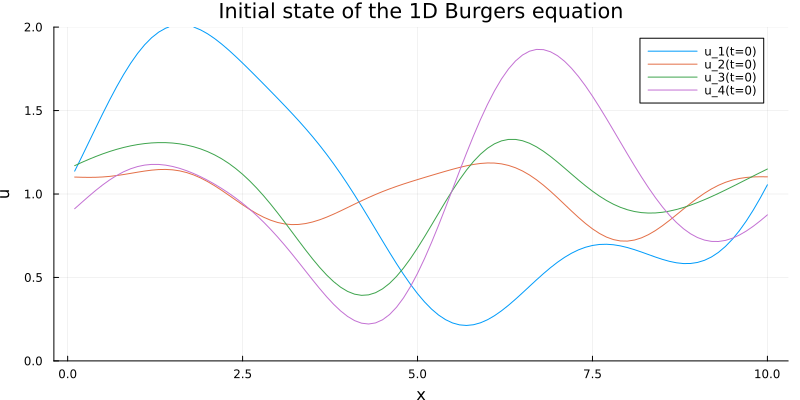

In [7]:
# plot the initial state
p1=plot(x, u0_all[1], label="u_1(t=0)", xlabel="x", ylabel="u")
plot!(p1,x, u0_all[2], label="u_2(t=0)", xlabel="x", ylabel="u")
plot!(p1,x, u0_all[3], label="u_3(t=0)", xlabel="x", ylabel="u")
plot!(p1,x, u0_all[4], label="u_4(t=0)", xlabel="x", ylabel="u")
plot(p1, size=(800,400), title="Initial state of the 1D Burgers equation",ylim=(0, 2))

In [8]:
# Run model for all initial conditions
sol_all=[]
for i in 1:n_ens
    println("Running simulation $i of $n_ens")
    u0=u0_all[i]
    prob = ODEProblem(f, u0, (t_start, t_end))
    @time sol = solve(prob, Tsit5(),saveat=10.0) # with timing, but ouput only at t=10.0
    sol = solve(prob, Tsit5()) # store output, no timing
    push!(sol_all, sol)
end

nothing

Running simulation 1 of 100
  0.886354 seconds (3.97 M allocations: 216.400 MiB, 5.61% gc time, 99.98% compilation time)
Running simulation 2 of 100
  0.000041 seconds (73 allocations: 19.859 KiB)
Running simulation 3 of 100
  0.000032 seconds (73 allocations: 19.859 KiB)
Running simulation 4 of 100
  0.000039 seconds (73 allocations: 19.859 KiB)
Running simulation 5 of 100
  0.000033 seconds (73 allocations: 19.859 KiB)
Running simulation 6 of 100
  0.000045 seconds (73 allocations: 19.859 KiB)
Running simulation 7 of 100
  0.000040 seconds (73 allocations: 19.859 KiB)
Running simulation 8 of 100
  0.000036 seconds (73 allocations: 19.859 KiB)
Running simulation 9 of 100
  0.000035 seconds (73 allocations: 19.859 KiB)
Running simulation 10 of 100
  0.000030 seconds (73 allocations: 19.859 KiB)
Running simulation 11 of 100
  0.000038 seconds (73 allocations: 19.859 KiB)
Running simulation 12 of 100
  0.000039 seconds (73 allocations: 19.859 KiB)
Running simulation 13 of 100
  0.000034 

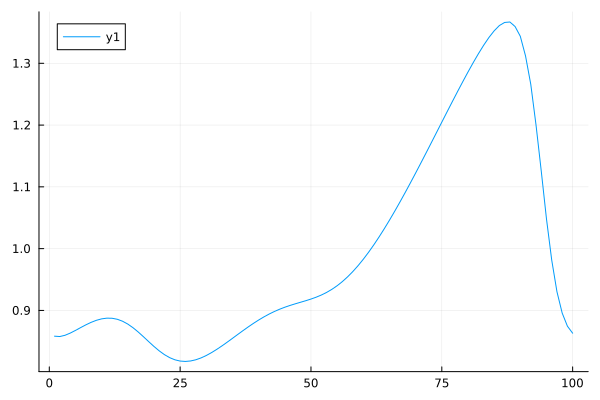

In [17]:
# look a some outputs

plot(sol_all[5](3.0))

In [18]:
# save the solution to a JLD2 file
cfl_out=1.0 # CFL number for output
dt_out=cfl_out*f.Δx/u_mean # time step for output, based on CFL condition
times=collect(0.0:dt_out:t_end) # output times
n_ens=length(sol_all)
n_times=length(times)
solution=[] # store as nested array: solution[ens][time]
for i in 1:n_ens
    sol=sol_all[i]
    temp_solution=[]
    for t in times
        push!(temp_solution, sol(t))
    end
    push!(solution, temp_solution)
end
# save the solution to a JLD2 file
save("burgers1d_periodic_ensemble.jld2", 
    "solution", solution,
    "times", times,
    "params", (ν=ν, Δx=Δx, u_mean=u_mean, u_amplitude=u_amplitude, k=k),
    "grid", x,
    "cfl_out", cfl_out,
    "dt_out", dt_out,
    "description", "Solution of the 1D Burgers equation with periodic boundary conditions, using an ensemble of initial condition.")


In [23]:
# load the solution from the JLD2 file for testing
ff=load("burgers1d_periodic_ensemble.jld2")

@show ff["solution"][1:20:end,1,1] # show some values of the initial velocity field

(ff["solution"])[1:20:end, 1, 1] = Any[Any[[1.1369413170937226, 1.221784001726801, 1.3083053726698497, 1.3950839689770458, 1.4806650095548726, 1.5636030692160328, 1.6425052708110506, 1.7160732799251217, 1.7831423734218972, 1.8427159225670076, 1.8939937855748168, 1.936393338444486, 1.969562177507747, 1.9933818885908454, 2.0079626789148484, 2.0136290889536994, 2.010897420946981, 2.000445916691145, 1.983079068463003, 1.9596877343100603, 1.9312069364261535, 1.8985733369249835, 1.8626844018206783, 1.8243611794667745, 1.7843164375581475, 1.7431296318158838, 1.7012298332518065, 1.6588873371778055, 1.6162142367912686, 1.5731737901738212, 1.5295979656047587, 1.4852121394021474, 1.4396655644453777, 1.3925659445021956, 1.3435162538917849, 1.2921518435079347, 1.238175877174927, 1.1813912456073299, 1.1217273024129422, 1.059260046168471, 0.9942247188796581, 0.9270201850178899, 0.8582048754460928, 0.7884845045007715, 0.7186921740846677, 0.6497618450804399, 0.582696465514208, 0.5185322819922698, 0.458

5-element Vector{Any}:
 Any[[1.1369413170937226, 1.221784001726801, 1.3083053726698497, 1.3950839689770458, 1.4806650095548726, 1.5636030692160328, 1.6425052708110506, 1.7160732799251217, 1.7831423734218972, 1.8427159225670076  …  0.6027035903773715, 0.6226639136591763, 0.6502491925248458, 0.6857364361329644, 0.729212364530833, 0.7805615577523174, 0.8394600644099217, 0.9053751398000097, 0.9775715853793936, 1.0551249178343933], [1.0531464522050933, 1.1281040979523367, 1.2054632188099172, 1.2842455307072913, 1.3634396210083097, 1.4420153304437895, 1.5189381346311766, 1.5931839169781188, 1.6637545288737559, 1.7296944776395242  …  0.5962049330441934, 0.6117394445299119, 0.6342151049541206, 0.6638293836058019, 0.7006049395020063, 0.7443953513799386, 0.7948954506691553, 0.8516549551605017, 0.9140941713742685, 0.9815207160822175], [0.984627156506382, 1.0511704414080354, 1.120382672682905, 1.1915486420703005, 1.2639353680657892, 1.3367967463183206, 1.4093772637789197, 1.4809152626627669, 1.550

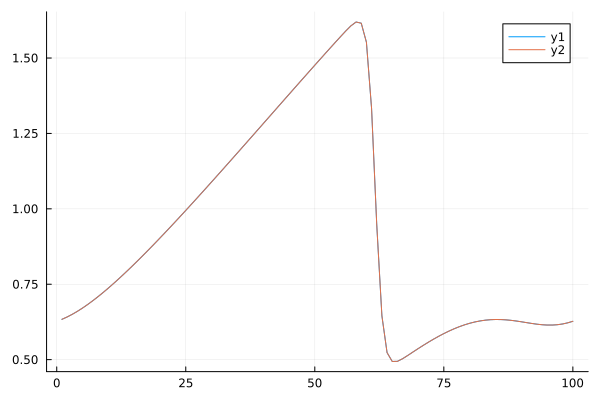

In [24]:
#check if the loaded solution is the same as the one we had before
plot(ff["solution"][70][40])
plot!(solution[70][40]) # should be the same as above